In [6]:
!pip install matminer

Dataset shape: (1306, 6)
      formula a_1 b_1 a_2 b_2  gap gllbsc
0  AgNbLaAlO6  Ag  Nb  La  Al    4.164543
1  AgNbLaGaO6  Ag  Nb  La  Ga    4.454629
2  AgNbLaInO6  Ag  Nb  La  In    4.192522
3  AgNbMgTiO6  Ag  Nb  Mg  Ti    3.963857
4  AgNbSnTiO6  Ag  Nb  Sn  Ti    2.881239
5   AgNbYAlO6  Ag  Nb   Y  Al    3.958215
6  AgTaAgNbO6  Ag  Ta  Ag  Nb    3.367340
7  AgTaBaSnO6  Ag  Ta  Ba  Sn    4.115528
8  AgTaBaTiO6  Ag  Ta  Ba  Ti    3.651875
9  AgTaCaGeO6  Ag  Ta  Ca  Ge    4.596742
Baseline R²: 0.941, RMSE: 0.377


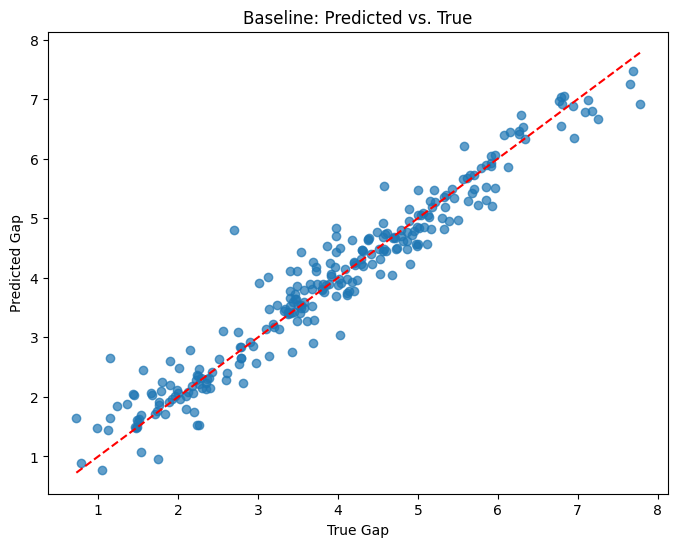

Noise 0.05 -> R²: 0.847, RMSE: 0.608
Noise 0.2 -> R²: 0.847, RMSE: 0.608


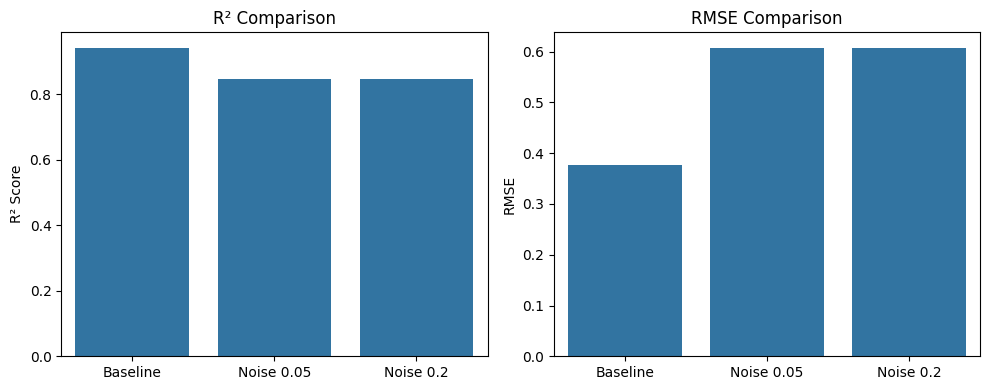

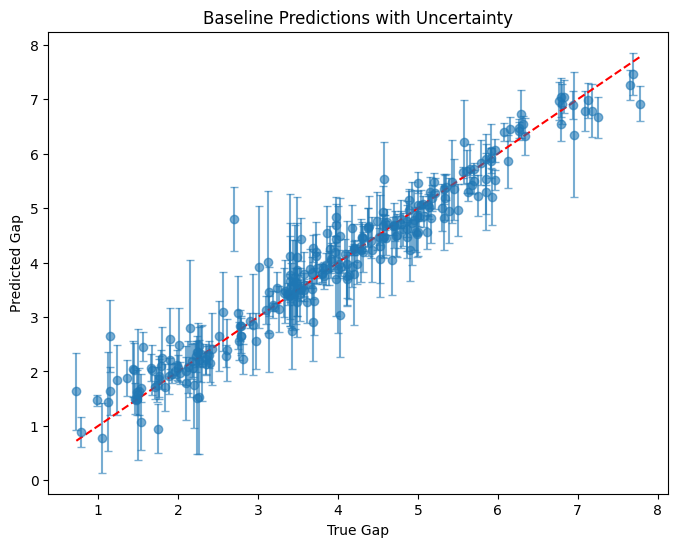

Conformal 95% Coverage: 0.947, Avg. Interval Width: 1.886


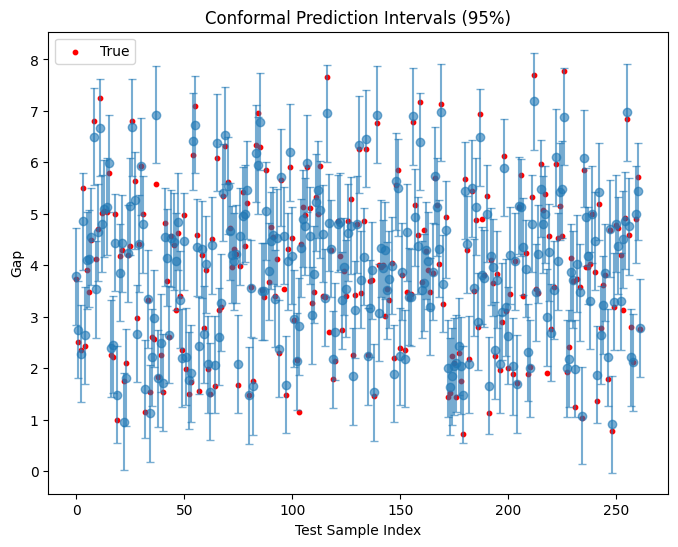

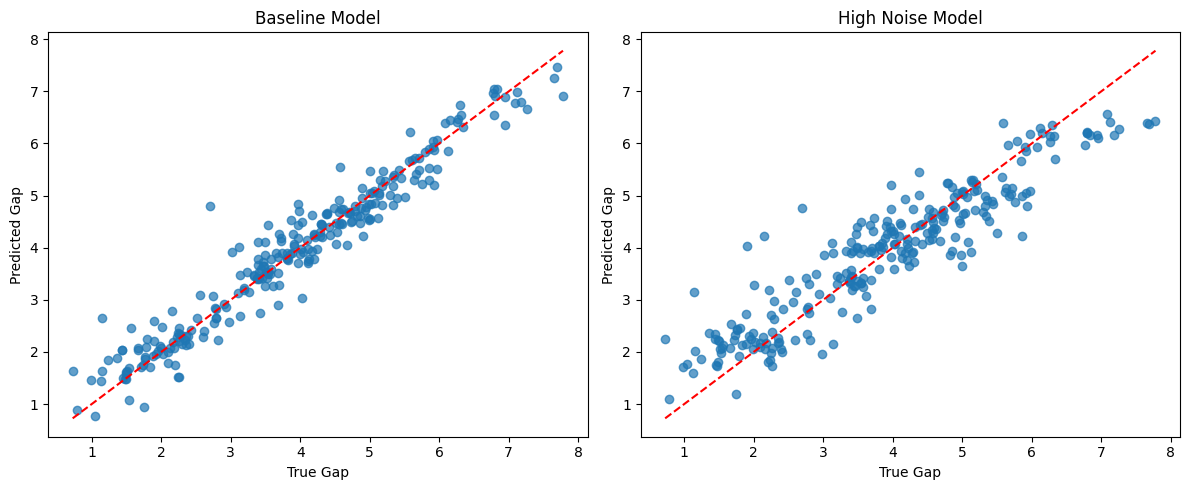

Baseline Avg. Uncertainty: 0.412
High Noise Avg. Uncertainty: 0.876


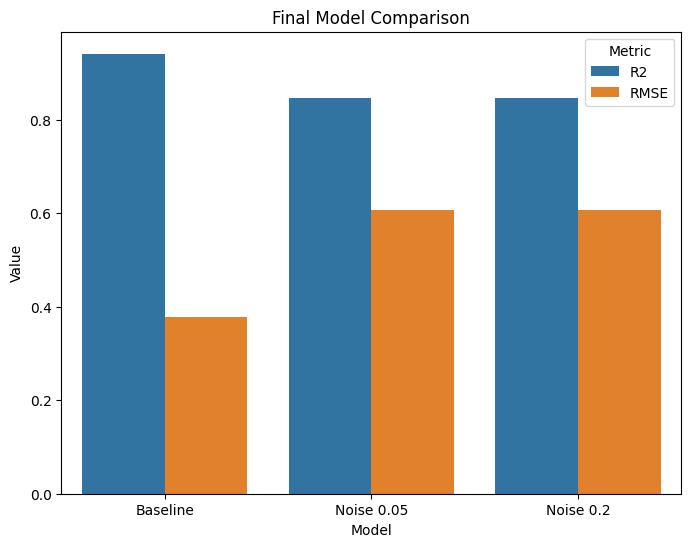

In [7]:
# %% [markdown]
"""
# Notebook 1: Handling Aleatoric Uncertainty (Noise & Overlapping Data)
This notebook simulates measurement noise in the Double Perovskites Gap dataset. We:
- Load and preprocess the dataset.
- Train a baseline RandomForest regressor.
- Add Gaussian noise at two levels (low & high) to simulate aleatoric uncertainty.
- Evaluate regression performance (R², RMSE) and visualize predicted vs. true values.
- Estimate uncertainty via ensemble variance.
- Compute conformal prediction intervals to quantify uncertainty (coverage, efficiency).
- Compare performance and uncertainty before/after applying denoising/ensemble techniques.
"""
# %% [code]
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
from matminer.datasets import load_dataset

# Load dataset
df = load_dataset("double_perovskites_gap", download_if_missing=True)
print("Dataset shape:", df.shape)
print(df.head(10))

# %% [code]
# Preprocess: drop 'formula' and one-hot encode elemental labels
df_proc = df.drop(columns=["formula"])
df_proc = pd.get_dummies(df_proc, columns=["a_1", "b_1", "a_2", "b_2"])
X = df_proc.drop(columns=["gap gllbsc"]).values
y = df_proc["gap gllbsc"].values

# Split & scale
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# %% [code]
# Cell 3: Train Baseline Model (No Noise)
rf_base = RandomForestRegressor(n_estimators=100, random_state=42)
rf_base.fit(X_train, y_train)
y_pred_base = rf_base.predict(X_test)
r2_base = r2_score(y_test, y_pred_base)
rmse_base = np.sqrt(mean_squared_error(y_test, y_pred_base))
print(f"Baseline R²: {r2_base:.3f}, RMSE: {rmse_base:.3f}")

# Plot Predicted vs. True
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred_base, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("True Gap")
plt.ylabel("Predicted Gap")
plt.title("Baseline: Predicted vs. True")
plt.show()

# %% [code]
# Cell 4: Adding Noise to Features (Low & High Noise)
noise_levels = [0.05, 0.2]
results_noise = {}

for noise in noise_levels:
    np.random.seed(42)
    X_train_noise = X_train + np.random.normal(0, noise, X_train.shape)
    X_test_noise  = X_test + np.random.normal(0, noise, X_test.shape)

    rf_noise = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_noise.fit(X_train_noise, y_train)
    y_pred_noise = rf_noise.predict(X_test_noise)
    r2_noise = r2_score(y_test, y_pred_noise)
    rmse_noise = np.sqrt(mean_squared_error(y_test, y_pred_noise))
    results_noise[noise] = {"model": rf_noise, "pred": y_pred_noise,
                            "r2": r2_noise, "rmse": rmse_noise, "X_test": X_test_noise}
    print(f"Noise {noise} -> R²: {r2_noise:.3f}, RMSE: {rmse_noise:.3f}")

# Bar plots for performance metrics
labels = ["Baseline"] + [f"Noise {n}" for n in noise_levels]
r2_vals = [r2_base] + [results_noise[n]["r2"] for n in noise_levels]
rmse_vals = [rmse_base] + [results_noise[n]["rmse"] for n in noise_levels]

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
sns.barplot(x=labels, y=r2_vals)
plt.ylabel("R² Score")
plt.title("R² Comparison")
plt.subplot(1,2,2)
sns.barplot(x=labels, y=rmse_vals)
plt.ylabel("RMSE")
plt.title("RMSE Comparison")
plt.tight_layout()
plt.show()

# %% [code]
# Cell 5: Model Performance on Noisy Data - Ensemble Uncertainty
# Compute ensemble predictions from individual trees
def ensemble_uncertainty(model, X):
    preds = np.array([est.predict(X) for est in model.estimators_])
    return preds.mean(axis=0), preds.std(axis=0)

# Baseline uncertainty
mean_base, std_base = ensemble_uncertainty(rf_base, X_test)
plt.figure(figsize=(8,6))
plt.errorbar(y_test, mean_base, yerr=std_base, fmt='o', alpha=0.6, capsize=3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("True Gap")
plt.ylabel("Predicted Gap")
plt.title("Baseline Predictions with Uncertainty")
plt.show()

# %% [code]
# Cell 7: Conformal Prediction for Aleatoric Uncertainty
# Split a calibration set from training data
X_train_cal, X_cal, y_train_cal, y_cal = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
rf_cal = RandomForestRegressor(n_estimators=100, random_state=42)
rf_cal.fit(X_train_cal, y_train_cal)
y_cal_pred = rf_cal.predict(X_cal)
# Absolute residuals from calibration set
residuals = np.abs(y_cal - y_cal_pred)
alpha = 0.95
q = np.quantile(residuals, alpha)  # quantile for 95% prediction interval

# Compute prediction intervals on test set
y_test_pred = rf_cal.predict(X_test)
lower = y_test_pred - q
upper = y_test_pred + q
coverage = np.mean((y_test >= lower) & (y_test <= upper))
avg_width = np.mean(upper - lower)
print(f"Conformal 95% Coverage: {coverage:.3f}, Avg. Interval Width: {avg_width:.3f}")

# Plot prediction intervals
plt.figure(figsize=(8,6))
plt.errorbar(np.arange(len(y_test)), y_test_pred, yerr=q, fmt='o', alpha=0.6, capsize=3)
plt.scatter(np.arange(len(y_test)), y_test, color='red', s=10, label="True")
plt.xlabel("Test Sample Index")
plt.ylabel("Gap")
plt.title("Conformal Prediction Intervals (95%)")
plt.legend()
plt.show()

# %% [code]
# Cell 8: Reducing Aleatoric Uncertainty via Denoising/Ensembles
# Here we simulate "denoising" by applying robust scaling (already did StandardScaler) and using ensembles.
# For demonstration, we simply compare the baseline ensemble (already robust) with the noisy models.
# (In practice, one might apply smoothing or feature selection.)
# Plot decision scatter: True vs. Predicted for baseline and high-noise model
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.scatter(y_test, y_pred_base, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title("Baseline Model")
plt.xlabel("True Gap")
plt.ylabel("Predicted Gap")
plt.subplot(1,2,2)
y_pred_high = results_noise[0.2]["pred"]
plt.scatter(y_test, y_pred_high, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title("High Noise Model")
plt.xlabel("True Gap")
plt.ylabel("Predicted Gap")
plt.tight_layout()
plt.show()

# %% [code]
# Cell 9: Final Comparison of Models
# Summarize performance & uncertainty metrics: R², RMSE, and ensemble std (average uncertainty)
avg_uncertainty_base = np.mean(std_base)
avg_uncertainty_high = np.mean(ensemble_uncertainty(results_noise[0.2]["model"], results_noise[0.2]["X_test"])[1])
print(f"Baseline Avg. Uncertainty: {avg_uncertainty_base:.3f}")
print(f"High Noise Avg. Uncertainty: {avg_uncertainty_high:.3f}")

# Final bar plot for performance metrics
perf_df = pd.DataFrame({
    "Model": ["Baseline", "Noise 0.05", "Noise 0.2"],
    "R2": [r2_base, results_noise[0.05]["r2"], results_noise[0.2]["r2"]],
    "RMSE": [rmse_base, results_noise[0.05]["rmse"], results_noise[0.2]["rmse"]]
})
perf_df_melted = perf_df.melt(id_vars="Model", var_name="Metric", value_name="Value")
plt.figure(figsize=(8,6))
sns.barplot(x="Model", y="Value", hue="Metric", data=perf_df_melted)
plt.title("Final Model Comparison")
plt.show()


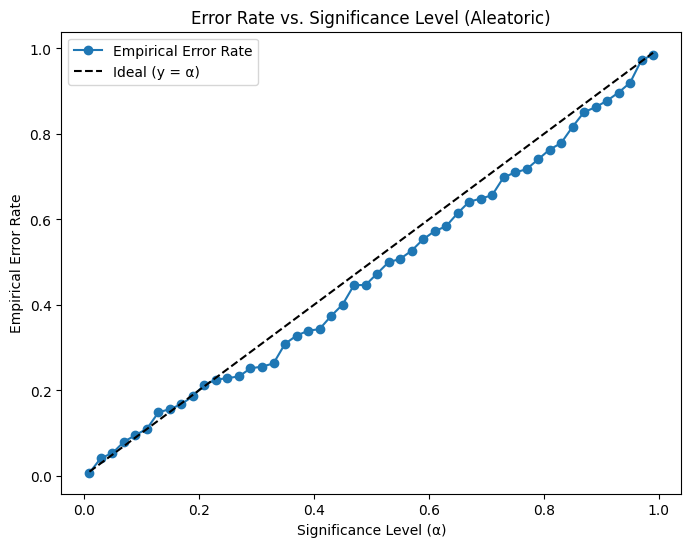

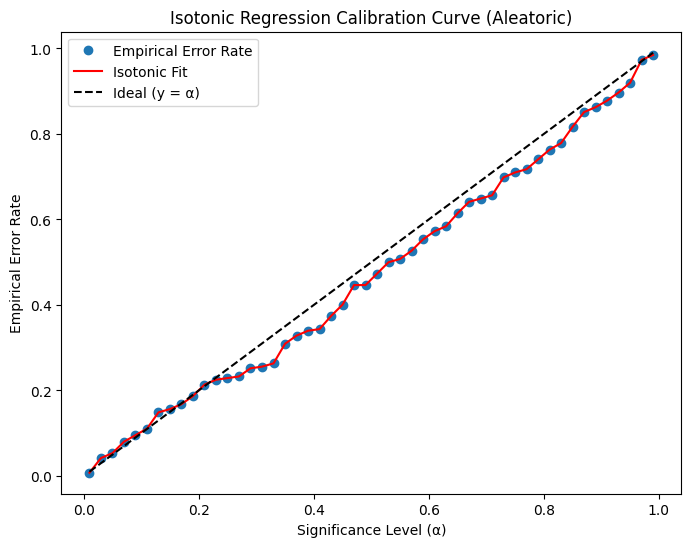

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.isotonic import IsotonicRegression

# --- Assumptions ---
# rf_cal: a RandomForestRegressor trained on a calibration split from (noise-free) training data.
# X_cal, y_cal: calibration set features and targets.
# X_test, y_test: test set features and targets.
# (These variables were defined earlier in Notebook 1.)

# Compute calibration residuals from the calibration set
y_cal_pred = rf_cal.predict(X_cal)
residuals_cal = np.abs(y_cal - y_cal_pred)

# Define a grid of significance levels (alpha)
alpha_grid = np.linspace(0.01, 0.99, 50)
empirical_error_rates = []

# Get test set predictions using the calibrated model (rf_cal)
y_test_pred = rf_cal.predict(X_test)

# For each significance level, compute the quantile and then the empirical error rate
for alpha in alpha_grid:
    # For desired significance level alpha, compute the corresponding quantile from calibration residuals
    q_alpha = np.quantile(residuals_cal, 1 - alpha)
    # Coverage: fraction of test samples whose absolute error is within q_alpha
    coverage = np.mean(np.abs(y_test - y_test_pred) <= q_alpha)
    empirical_error = 1 - coverage
    empirical_error_rates.append(empirical_error)

# Plot the empirical error rate vs. significance level
plt.figure(figsize=(8,6))
plt.plot(alpha_grid, empirical_error_rates, 'o-', label="Empirical Error Rate")
plt.plot(alpha_grid, alpha_grid, 'k--', label="Ideal (y = α)")
plt.xlabel("Significance Level (α)")
plt.ylabel("Empirical Error Rate")
plt.title("Error Rate vs. Significance Level (Aleatoric)")
plt.legend()
plt.show()

# --- Isotonic Regression Calibration ---
ir = IsotonicRegression(out_of_bounds='clip')
ir.fit(alpha_grid, empirical_error_rates)
alpha_fit = np.linspace(0.01, 0.99, 50)
error_fit = ir.predict(alpha_fit)

plt.figure(figsize=(8,6))
plt.plot(alpha_grid, empirical_error_rates, 'o', label="Empirical Error Rate")
plt.plot(alpha_fit, error_fit, 'r-', label="Isotonic Fit")
plt.plot(alpha_grid, alpha_grid, 'k--', label="Ideal (y = α)")
plt.xlabel("Significance Level (α)")
plt.ylabel("Empirical Error Rate")
plt.title("Isotonic Regression Calibration Curve (Aleatoric)")
plt.legend()
plt.show()
